In [1]:
# limit the thread used by numpy 
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"  
os.environ["MKL_NUM_THREADS"] = "1"

import numpy as np
import scipy.interpolate as interp 
try:
    import cupy as xp
    import cupyx.scipy.interpolate as xinterp
    # print("has cupy")
except (ImportError, ModuleNotFoundError) as e:
    import numpy as xp
    import scipy.interpolate as xinterp  
    # print("no cupy")

from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
# import matplotlib
# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['font.family'] = 'serif'

from Triangle.Constants import *
from Triangle.Orbit import * 
from Triangle.Noise import *
from Triangle.FFTTools import *
from Triangle.TDI import *
from Triangle.Data import * 

from Triangle_BBH.Waveform import * 
from Triangle_BBH.Response import *
from Triangle_BBH.Utils import *
from Triangle_BBH.Fisher import *

np.random.seed(114514)
xp.random.seed(114514)

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


has cupy
has BBHx waveform


## Load data 

In [2]:
h5filename = "/media/ps/One Touch/TDCII_Data/0_Verification_Dataset/data/VMBHB.h5"
with h5py.File(h5filename, "r") as h5file: 
    read_dict = read_dict_from_h5(h5file["/"])
read_dict.keys()

dict_keys(['eta', 'parameters', 'time'])

## TDI combination 

In [3]:
ORBIT_DIR = "/home/ps/workspace/Triangle-Simulator/OrbitData/MicroSateOrbitEclipticTCB"
orbit = Orbit(OrbitDir=ORBIT_DIR)

ltts = dict() 
for key in MOSA_labels: 
    ltts[key] = orbit.LTTfunctions()[key](read_dict["time"])
ltts = MOSADict(ltts)

m = {"eta" : read_dict["eta"]}
fsample = 1. / (read_dict["time"][1] - read_dict["time"][0])

tdi = TDI(measurements=m, delays=ltts, fsample=fsample, order=31) 
tdi.FastMichelson(channel="AET")

channel_names = ["A2", "E2", "T2"]
for nch in channel_names: 
    tdi.measurements[nch][:1500] = 0. 
    tdi.measurements[nch][-1500:] = 0. 

data_time = read_dict["time"]

## Downsample 

In [4]:
for nch in channel_names: 
    tdi.measurements[nch] = downsampling(data=tdi.measurements[nch], fsample=fsample, downsample=5, kaiser_filter_coef=[240, 0.04, 0.16])
    tdi.measurements[nch][:400] = 0. 
    tdi.measurements[nch][-400:] = 0. 
data_time = read_dict["time"][::5]
fsample = 1. / (data_time[1] - data_time[0])

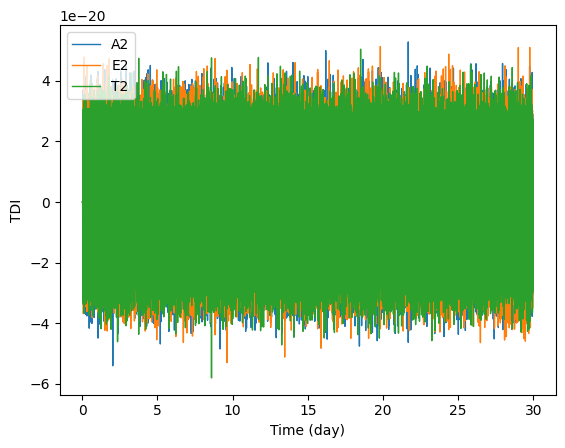

In [5]:
for nch in channel_names: 
    plt.plot(data_time/DAY, tdi.measurements[nch], linewidth=1, label=nch)
plt.xlabel("Time (day)")
plt.ylabel("TDI")
plt.legend(loc = "upper left")

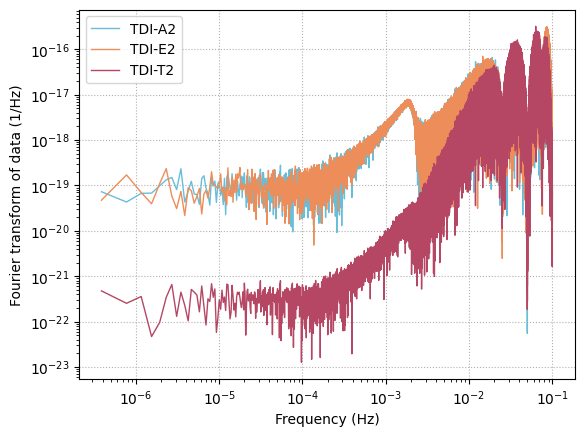

In [6]:
data_channels = [] 
for ich, nch, cch in zip(range(3), channel_names, [BLUE, ORANGE, RED]):
    ff, xf = FFT_window(tdi.measurements[nch], fsample, window_type="tukey", window_args_dict=dict(alpha=0.05))
    plt.loglog(ff, np.abs(xf), linewidth=1, color=cch, label="TDI-"+nch)
    data_channels.append(xf)
data_frequency = ff 
data_channels = np.array(data_channels)

plt.xlabel("Frequency (Hz)")
plt.ylabel("Fourier transform of data (1/Hz)")
plt.legend(loc="upper left")
plt.grid(linestyle=":")

Assuming an initial search step, we limit the frequency band

In [7]:

freq_idx = np.where((data_frequency<5e-3)&(data_frequency>5e-5))[0]

data_frequency = xp.array(data_frequency[freq_idx])
delta_f = data_frequency[1] - data_frequency[0]
Tobs = 1. / delta_f

data_channels = xp.array(data_channels[:, freq_idx])

fiducial_parameters = read_dict["parameters"]

data_frequency.shape, data_channels.shape 

((12830,), (3, 12830))

## Prepare models 

### waveform and response 

In [8]:
mode = "primary"
use_gpu = True 

# initialize  waveform generator 
WFG = BBHxWaveformGenerator(mode=mode, use_gpu=use_gpu)

# initialize response generator 
FDTDI = BBHxFDTDIResponseGenerator(orbit_class=orbit, waveform_generator=WFG, use_gpu=use_gpu)

# response settings 
response_kwargs = dict(
    modes=[(2,2),], 
    tmin=data_time[0]/DAY,
    tmax=data_time[-1]/DAY, 
    tc_at_constellation=False, 
    TDIGeneration="2nd", # "1st" or "2nd"
    optimal_combination=True, # True for AET, False for XYZ 
    output_by_mode=False, 
    interpolation=True ,
)

response_kwargs

{'modes': [(2, 2)],
 'tmin': 0.0,
 'tmax': 29.99994212962963,
 'tc_at_constellation': False,
 'TDIGeneration': '2nd',
 'optimal_combination': True,
 'output_by_mode': False,
 'interpolation': True}

## Model noise 
- Notice that AET channels are only approximately independent. 
- The noise level of T channel varies significantly with time, thus we do not use T channel in subsequent analysis. 
- During realistic search we usually do not priorly know the PSD of noise 

In [9]:
# noise PSD model 
PSDfunc = TDIPSDs()

# use the median time to calculate armlengths, this is only an approximation 
arm_time = (data_time[0] + data_time[-1]) / 2. 
arms = dict()
for key in MOSA_labels:
    arms[key] = orbit.LTTfunctions()[key](arm_time)
print("arm time (day):", arm_time / DAY)
print("arm lengths:", arms)

# T will not be used 
PSD_channels = xp.array([
    PSDfunc.PSD_A2_unequal(data_frequency.get(), arms), 
    PSDfunc.PSD_E2_unequal(data_frequency.get(), arms), 
    PSDfunc.PSD_T2_unequal(data_frequency.get(), arms)
])

# covariance matrix, this is also an approximate since the channels should be correlated under the unequal-arm regime
CovMat = xp.array([
    [PSD_channels[0], xp.zeros_like(PSD_channels[0]), xp.zeros_like(PSD_channels[0])],
    [xp.zeros_like(PSD_channels[0]), PSD_channels[1], xp.zeros_like(PSD_channels[0])],
    [xp.zeros_like(PSD_channels[0]), xp.zeros_like(PSD_channels[0]), PSD_channels[2]]
]) / 4. / delta_f # (3, 3, Nf)

# inverse of covmatrix
InvCovMat = xp.linalg.inv(xp.transpose(CovMat, (2, 0, 1))) # (Nf, 3, 3)

PSD_channels.shape, InvCovMat.shape 

arm time (day): 14.999971064814815
arm lengths: {'12': array(9.96294132), '13': array(9.97838133), '23': array(10.00655378), '21': array(9.96366138), '31': array(9.9779859), '32': array(10.00542111)}


((3, 12830), (12830, 3, 3))

## Test model with the true parameters 

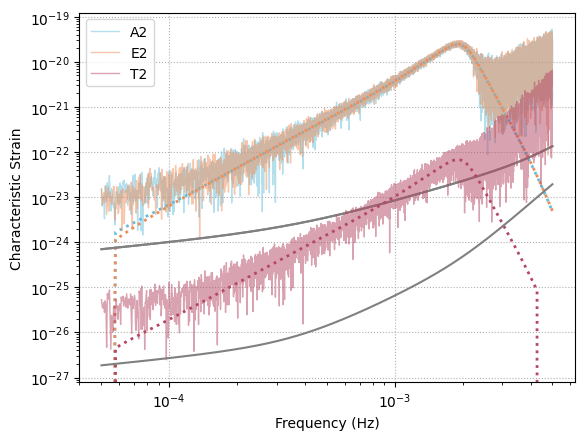

In [10]:
model_channels = FDTDI.Response(parameters=fiducial_parameters, freqs=data_frequency, **response_kwargs)

for ich, nch, cch in zip(range(3), channel_names, [BLUE, ORANGE, RED]):
    plt.loglog(data_frequency.get(), np.abs(data_channels[ich].get()) * data_frequency.get() * 2., label=nch, linewidth=1, color=cch, alpha=0.5)
    plt.loglog(data_frequency.get(), np.abs(model_channels[ich].get()) * data_frequency.get() * 2., linewidth=2, linestyle=":", color=cch)
    plt.loglog(data_frequency.get(), np.sqrt(PSD_channels[ich] * data_frequency).get(), color="grey")

plt.legend(loc="upper left")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Characteristic Strain")
plt.grid(linestyle=":")

## Use A, E channels only 
set $C^{-1}_{T_2 T_2} \equiv 0$ to eliminate the contribution of $T_2$

In [11]:
InvCovMat[:, 2, 2] *= 0. 

## Likelihood

In [12]:
Like = Likelihood(
    response_generator=FDTDI, 
    frequency=data_frequency, 
    data=data_channels, 
    invserse_covariance_matrix=InvCovMat, 
    response_parameters=response_kwargs, 
    use_gpu=use_gpu,
)

number of freuqncies: 12830
min and max frequencies: 5.015432098765432e-05 0.0049996141975308635
response kwargs: {'modes': [(2, 2)], 'tmin': 0.0, 'tmax': 29.99994212962963, 'tc_at_constellation': False, 'TDIGeneration': '2nd', 'optimal_combination': True, 'output_by_mode': False, 'interpolation': True}


In [39]:
# fiducial_param_arr = ParamDict2ParamArr(fiducial_parameters)

# N_test=101
# test_idx = 4 # tc 
# test_params = np.linspace(-1e-2, 1e-2, N_test) + fiducial_param_arr[test_idx]

# tmp_params = np.zeros((11, N_test))
# for i_test in range(N_test):
#     tmp_params[:, i_test] = fiducial_param_arr.copy()
#     tmp_params[test_idx][i_test] = test_params[i_test]
# test_lls_vec = Like.full_log_like_vectorized(tmp_params)
# plt.plot(test_params, test_lls_vec)

## Run MCMC Sampling 

the aim is to compare the posteriors of full and heterodyned likelihoods, so we choose ideal priors and starting points. 

In [14]:
from eryn.ensemble import EnsembleSampler
from eryn.state import State
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.utils import TransformContainer
from eryn.moves import GaussianMove, StretchMove, CombineMove
from eryn.utils.utility import groups_from_inds
from eryn.backends import HDFBackend
from eryn.utils import SearchConvergeStopping

from corner import corner

In [15]:
labels = [r"${\rm lg}\mathcal{M}_{c,z}$", r"$q$", r"$\chi_{z,1}$", r"$\chi_{z,2}$", r"$t_c$", r"$\varphi_c$", r"${\rm lg} D_L$", r"$\cos \iota$", r"$\lambda$", r"$\sin \beta$", r"$\psi$"]

truths = ParamDict2ParamArr(fiducial_parameters)

truths

[6.477121254719663,
 0.25,
 0.4,
 0.6,
 25.0,
 1.0471975511965976,
 4.678422538922767,
 0.30901699437494745,
 4.71238898038469,
 0.49999999999999994,
 0.9424777960769379]

In [16]:
# set hyper parameters
ndim = 11 # dimension of paramters 
nwalkers = 200 # number of random walkers, limited by the vRAM of my 4080S, use fewer (e.g. 100) to speed up and more (e.g. 400) to get more smooth posterior 
ntemps = 10 # number of temperatures used in parallel tempering 
temps = np.array(list(np.power(2., np.arange(ntemps - 1))) + [np.infty]) 
betas = 1. / temps 
tempering_kwargs=dict(betas=betas)

mcmc_moves = StretchMove(a=2) # mcmc move 

stop = None 

# set priors 
lim_lgMc = [6.4, 6.5]
lim_q = [0.1, 0.999]
lim_chiz1 = [-0.99, 0.99]
lim_chiz2 = [-0.99, 0.99]
lim_tc = [fiducial_parameters["coalescence_time"] - 2000/DAY, fiducial_parameters["coalescence_time"] + 2000/DAY] 
lim_phic = [0, TWOPI]
lim_lgD = [4., 5.]
lim_cosinc = [-1, 1]
lim_lam = [0, TWOPI]
lim_sinbeta = [-1, 1]
lim_psi = [0, PI]

lims = np.array([lim_lgMc, lim_q, lim_chiz1, lim_chiz2, lim_tc, lim_phic, lim_lgD, lim_cosinc, lim_lam, lim_sinbeta, lim_psi])
lower_lims = lims[:, 0]
upper_lims = lims[:, 1]

priors_in = {i: uniform_dist(lims[i][0], lims[i][1]) for i in range(ndim)}
priors = ProbDistContainer(priors_in)
priors.use_cupy = False

# set starting range 
start_lims = lims 
start_priors_in = {i: uniform_dist(start_lims[i][0], start_lims[i][1]) for i in range(ndim)}
start_priors = ProbDistContainer(start_priors_in)
start_priors.use_cupy = False

lims, start_lims

(array([[ 6.4       ,  6.5       ],
        [ 0.1       ,  0.999     ],
        [-0.99      ,  0.99      ],
        [-0.99      ,  0.99      ],
        [24.97685185, 25.02314815],
        [ 0.        ,  6.28318531],
        [ 4.        ,  5.        ],
        [-1.        ,  1.        ],
        [ 0.        ,  6.28318531],
        [-1.        ,  1.        ],
        [ 0.        ,  3.14159265]]),
 array([[ 6.4       ,  6.5       ],
        [ 0.1       ,  0.999     ],
        [-0.99      ,  0.99      ],
        [-0.99      ,  0.99      ],
        [24.97685185, 25.02314815],
        [ 0.        ,  6.28318531],
        [ 4.        ,  5.        ],
        [-1.        ,  1.        ],
        [ 0.        ,  6.28318531],
        [-1.        ,  1.        ],
        [ 0.        ,  3.14159265]]))

In [17]:
def eryn_like(params): 
    """params: numpy array of shape (Nevents, Nparams)"""
    return Like.full_log_like_vectorized(np.transpose(params))

In [18]:

ensemble = EnsembleSampler(
    nwalkers,
    ndim,
    eryn_like, 
    priors,
    args=[],
    tempering_kwargs=tempering_kwargs,
    stopping_fn=stop,
    stopping_iterations=10,
    moves=mcmc_moves,
    vectorize=True,
)

In [19]:
# randomize starting positions throughout prior
coords = start_priors.rvs(size=(ntemps, nwalkers,))
print(coords.shape)

thin_by = 100 
burn = 0
nsteps = int(100000 / thin_by) # should be more than enough 

ensemble.stopping_fn = None

out = ensemble.run_mcmc(coords, nsteps, burn=burn, progress=True, thin_by=thin_by)

(10, 200, 11)


 40%|████      | 40084/100000 [3:23:36<5:01:21,  3.31it/s]Traceback (most recent call last):
  File "/home/ps/miniconda3/envs/taiji_data/lib/python3.9/site-packages/eryn/ensemble.py", line 1584, in __call__
    out = self.f(*args_in, **kwargs_in)
  File "/tmp/ipykernel_272907/3181406468.py", line 3, in eryn_like
    return Like.full_log_like_vectorized(np.transpose(params))
  File "/home/ps/.local/lib/python3.9/site-packages/Triangle_BBH-0.1.0-py3.9.egg/Triangle_BBH/Utils.py", line 163, in full_log_like_vectorized
    template = self.response_generator.Response(
  File "/home/ps/.local/lib/python3.9/site-packages/Triangle_BBH-0.1.0-py3.9.egg/Triangle_BBH/Response.py", line 1093, in Response
    _, GTDI = self.TransferFunction(t=tgrids[mode], f=fgrids, k=k, Plm=Plm[mode], TDIGeneration=TDIGeneration, tmin=tmin, tmax=tmax)
  File "/home/ps/.local/lib/python3.9/site-packages/Triangle_BBH-0.1.0-py3.9.egg/Triangle_BBH/Response.py", line 964, in TransferFunction
    zero_inds = self.xp.where

eryn: Exception while calling your likelihood function:
  args added: [array([[ 6.4770289 ,  0.25036295,  0.39658456, ...,  4.77983058,
         0.34785809,  0.99023124],
       [ 6.47705566,  0.24936898,  0.40292602, ...,  4.60702823,
         0.34538527,  1.08769656],
       [ 6.47729418,  0.24953933,  0.40666517, ...,  4.67143039,
         0.26341789,  2.53063459],
       ...,
       [ 6.4570194 ,  0.26353124,  0.56099871, ...,  2.82725174,
        -0.03834822,  2.05383661],
       [ 6.49019146,  0.35439888, -0.55039886, ...,  3.44960107,
         0.50725008,  0.45888983],
       [ 6.47531415,  0.33392959,  0.07048309, ...,  2.82117339,
         0.48846997,  0.16290708]])]
  args: []
  kwargs added: {}
  kwargs: {}
  exception:


KeyboardInterrupt: 

In [32]:
# resume run after the run is stopped 
thin_by =100
burn = 0
nsteps = int(150000 / thin_by) # this should be far more than enough 

out = ensemble.run_mcmc(ensemble.get_last_sample(), nsteps, burn=burn, progress=True, thin_by=thin_by)

  0%|          | 738/150000 [03:37<12:14:22,  3.39it/s]Traceback (most recent call last):
  File "/home/ps/miniconda3/envs/taiji_data/lib/python3.9/site-packages/eryn/ensemble.py", line 1584, in __call__
    out = self.f(*args_in, **kwargs_in)
  File "/tmp/ipykernel_272907/3181406468.py", line 3, in eryn_like
    return Like.full_log_like_vectorized(np.transpose(params))
  File "/home/ps/.local/lib/python3.9/site-packages/Triangle_BBH-0.1.0-py3.9.egg/Triangle_BBH/Utils.py", line 174, in full_log_like_vectorized
    return np.real(-0.5 * loglikes.get())
KeyboardInterrupt
  0%|          | 738/150000 [03:37<12:13:05,  3.39it/s]

eryn: Exception while calling your likelihood function:
  args added: [array([[ 6.47701883,  0.24811574,  0.4120306 , ...,  2.78629944,
        -0.20790784,  2.08177285],
       [ 6.47745751,  0.25091237,  0.39586978, ...,  4.41150084,
         0.34844425,  2.52437026],
       [ 6.47750174,  0.24972614,  0.40489398, ...,  4.59385659,
         0.41199125,  0.98696101],
       ...,
       [ 6.41964692,  0.26172909,  0.95458028, ...,  0.67970254,
         0.89307517,  0.55330433],
       [ 6.43311158,  0.45465989, -0.17006864, ...,  3.14192834,
        -0.27875023,  2.18691239],
       [ 6.4761595 ,  0.39061747,  0.6788912 , ...,  2.76958436,
         0.67471707,  0.83413551]])]
  args: []
  kwargs added: {}
  kwargs: {}
  exception:


KeyboardInterrupt: 

## Show moves 

<Figure size 640x480 with 0 Axes>

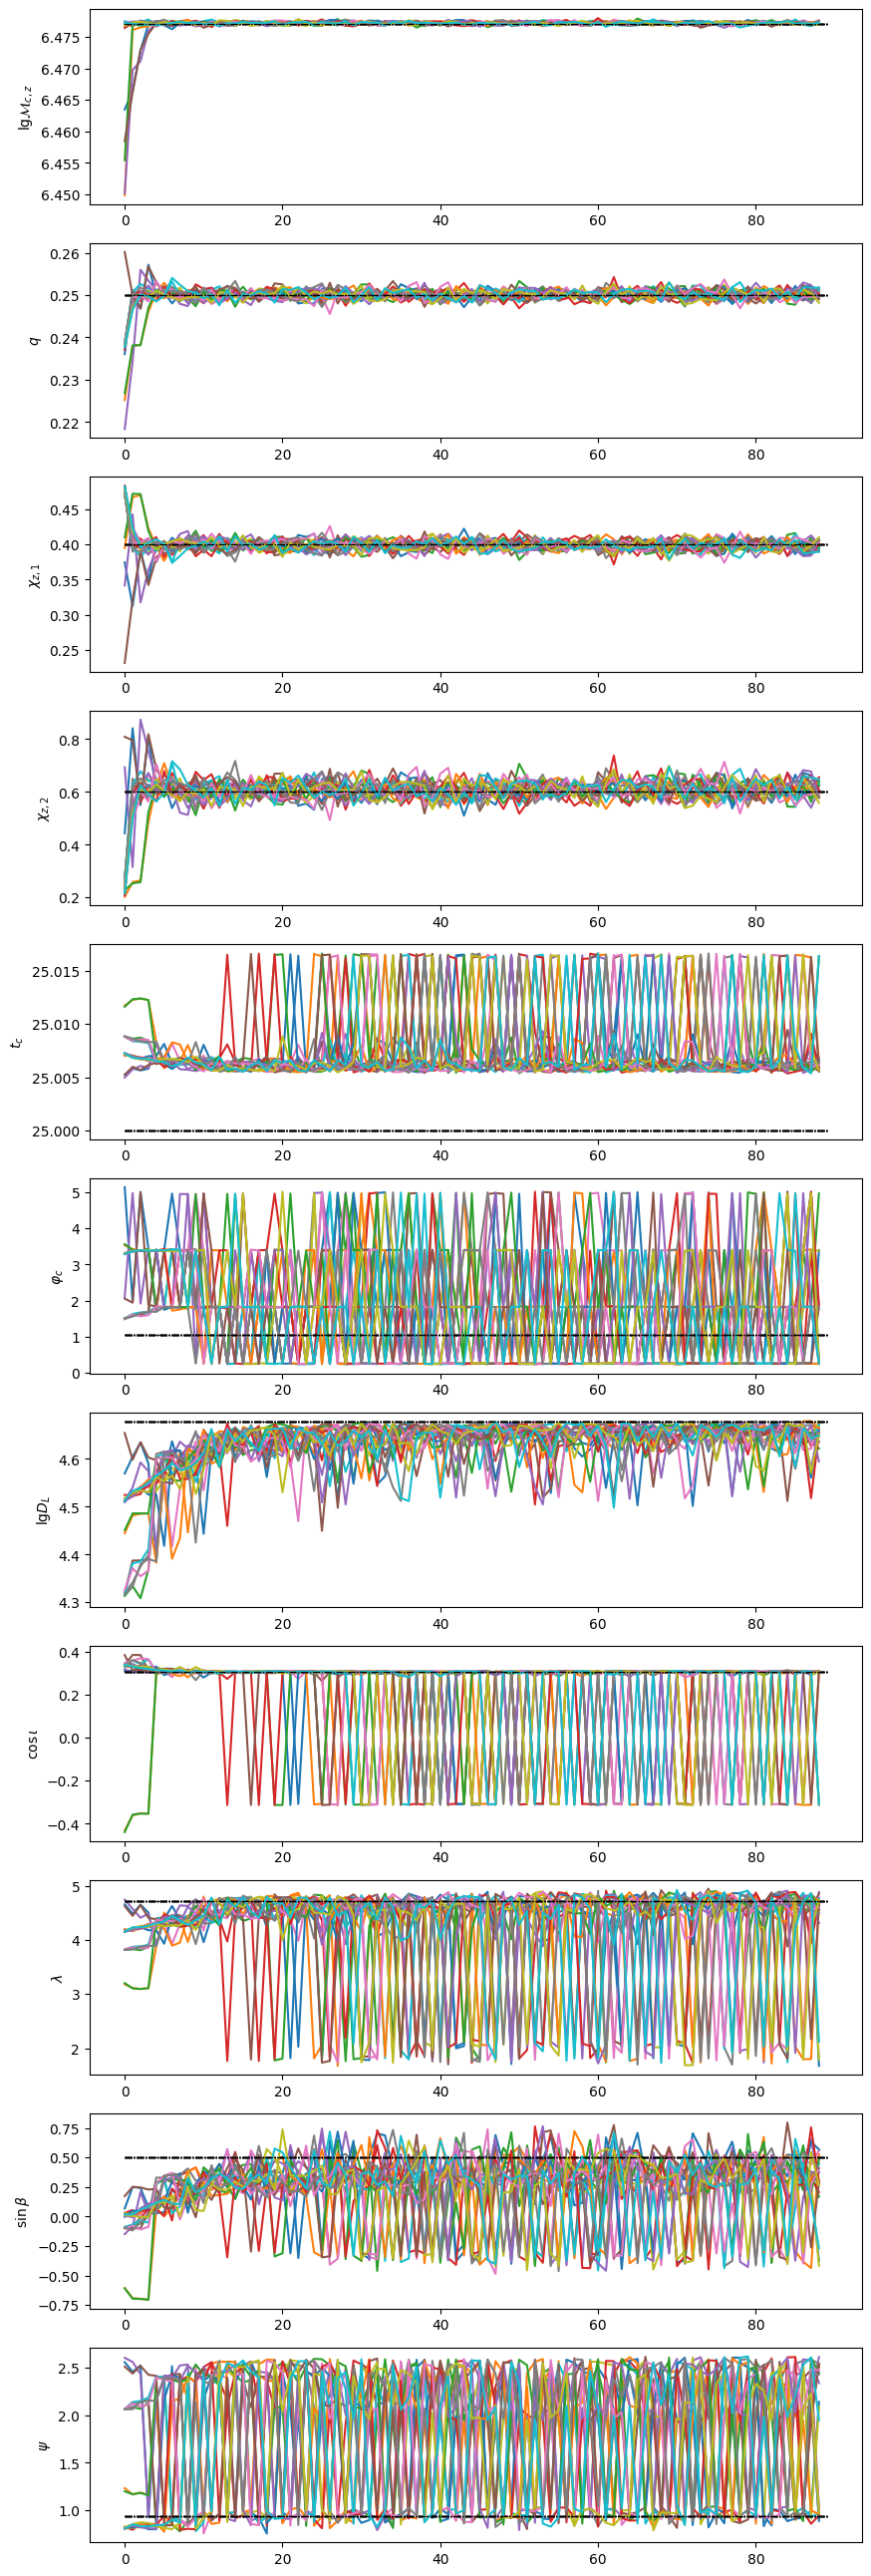

In [33]:
thin = 10
burnin = 0
len_chain = len(ensemble.get_chain(thin=thin, discard=burnin)['model_0'][:, 0, 0, :, 0])

plt.figure()
fig, ax = plt.subplots(ndim, 1)
fig.set_size_inches(10, 3*ndim)
for i in range(ndim):     
    for walk in range(20): # plot 20 walkers 
        ax[i].plot(ensemble.get_chain(thin=thin, discard=burnin)['model_0'][:, 0, walk, 0, i])
        ax[i].hlines(truths[i], 0, len_chain, color='k', linestyle='-.', linewidth=0.8)
    ax[i].set_ylabel(labels[i])

## Corner plot
$t_c$ and $\varphi_c$ are not perfectly matched, the reason of which is explaned in Example 3.

sample shape: (1800, 11)


<Figure size 640x480 with 0 Axes>

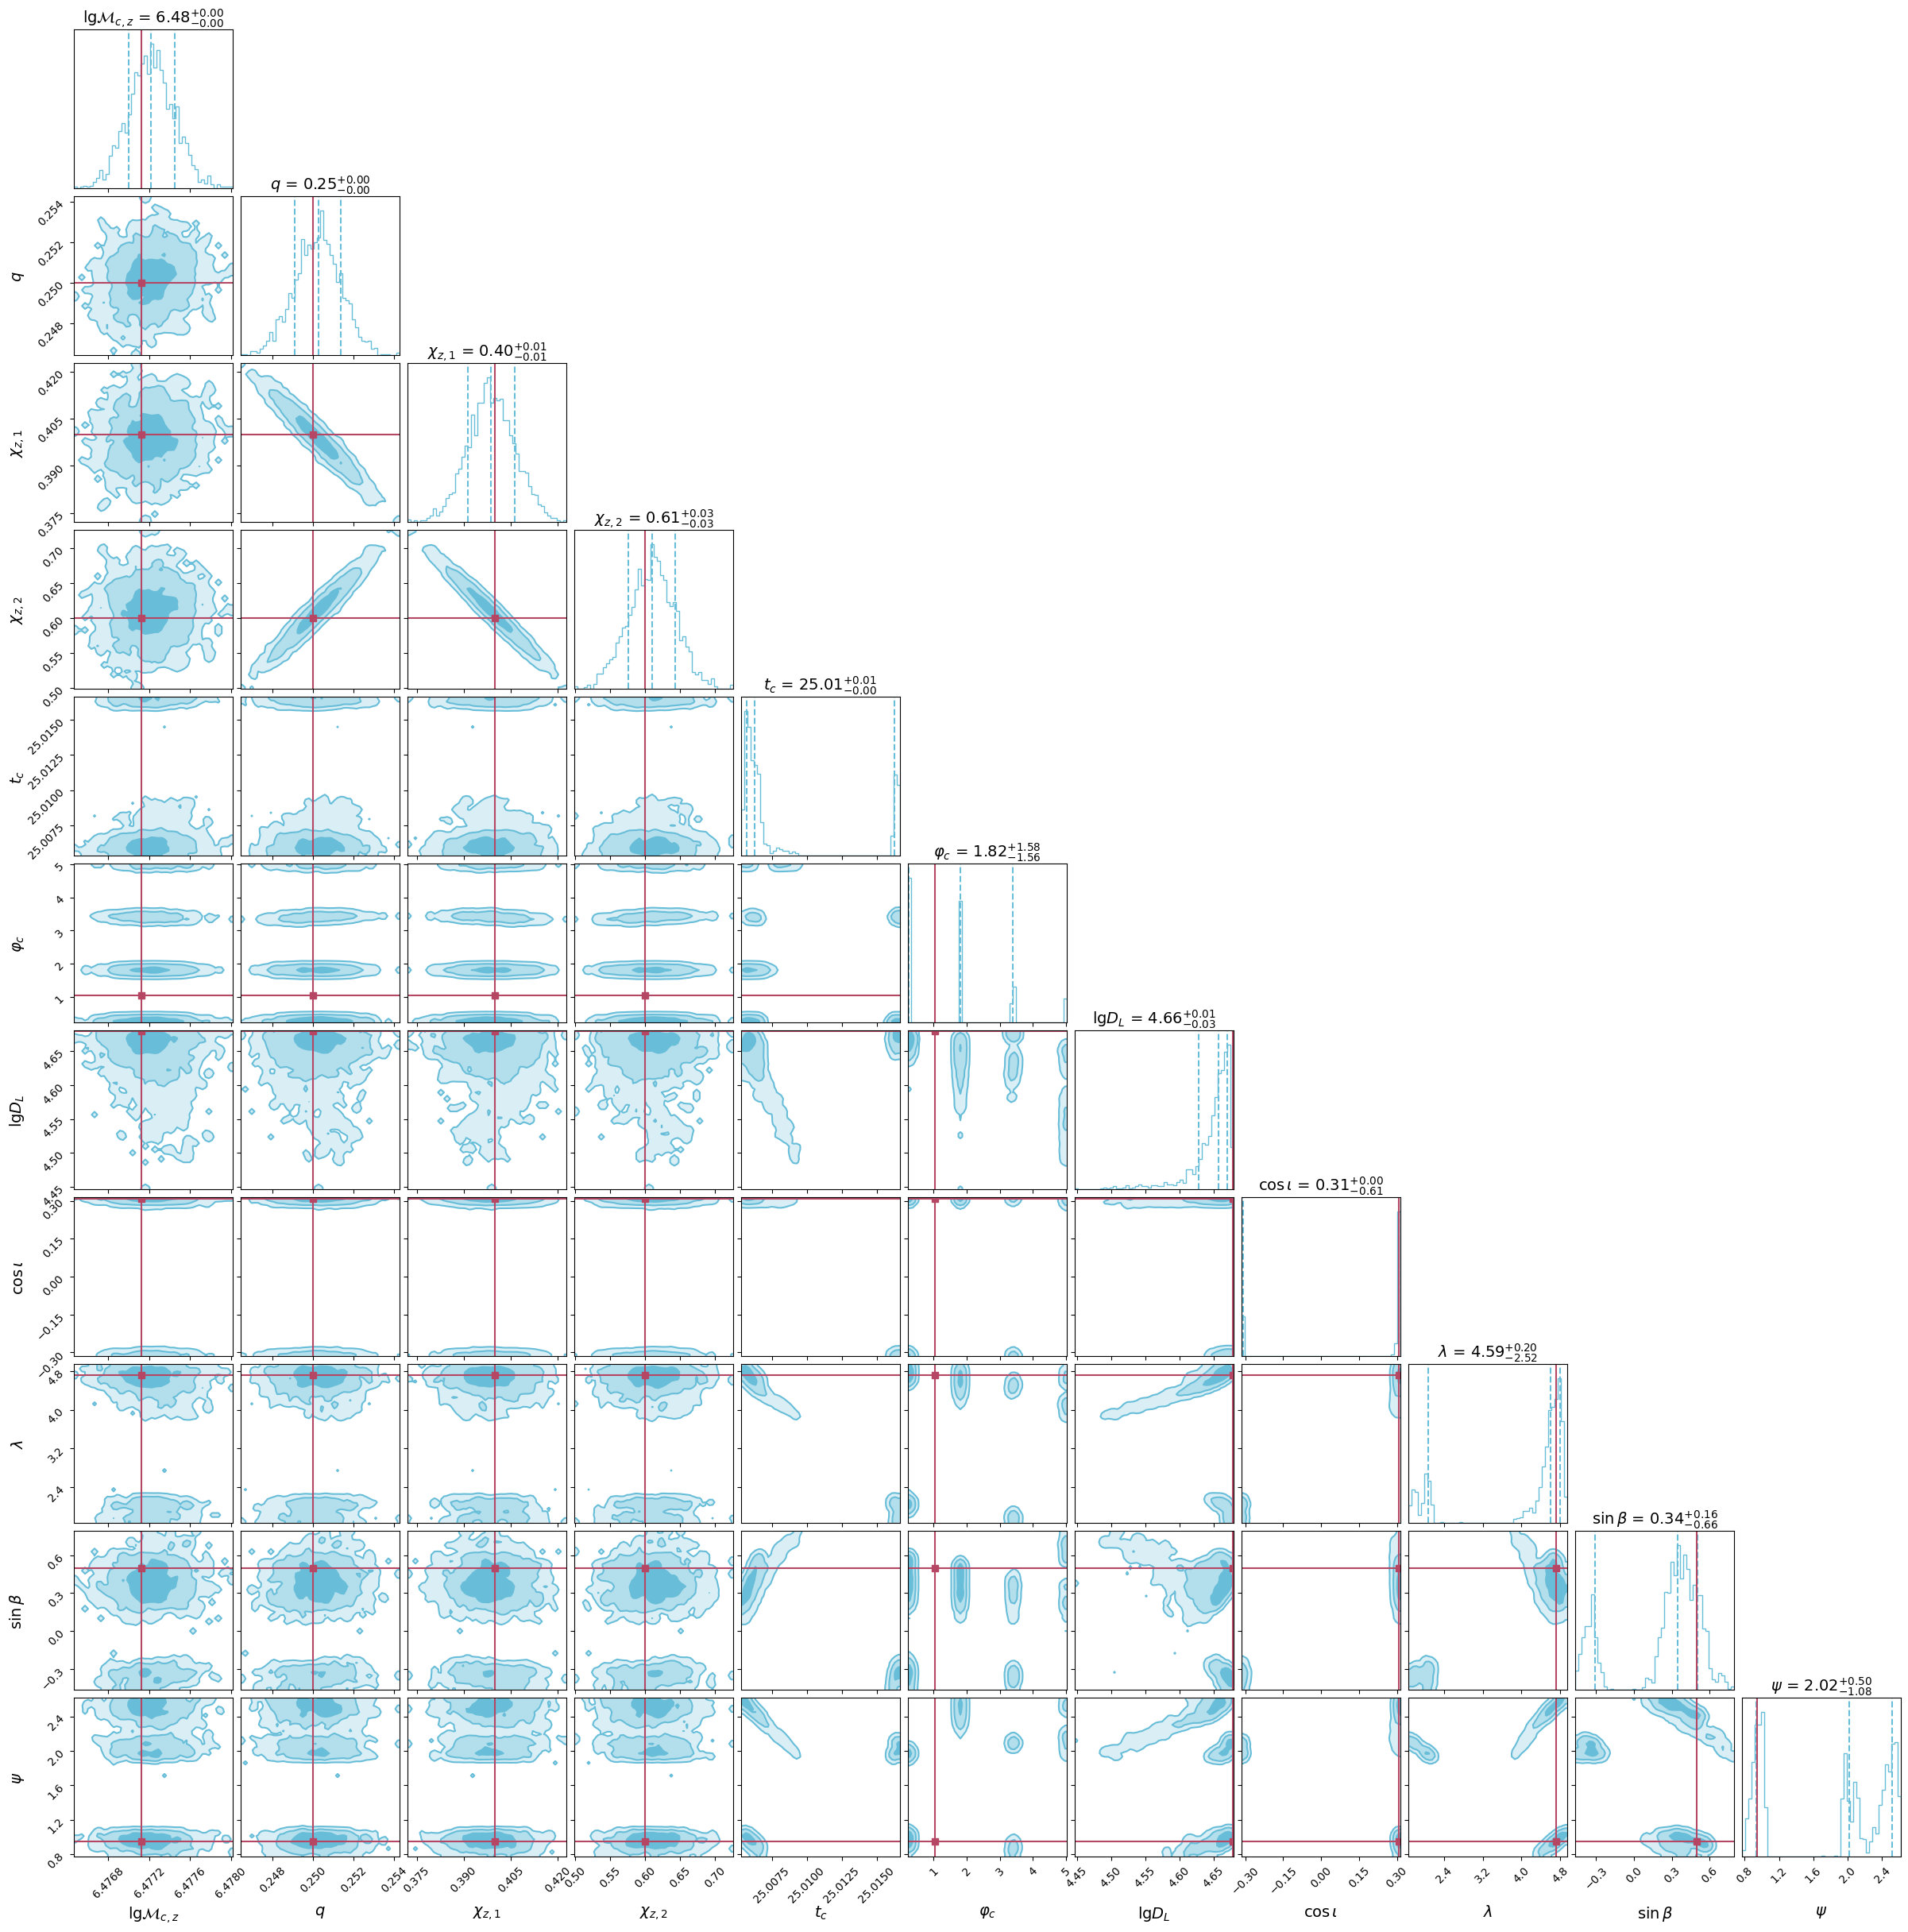

In [49]:
burnin=500
thin = 40

samp = ensemble.get_chain(discard=burnin, thin=thin)['model_0'][:, 0, :, :, :].reshape(-1, ndim)
print("sample shape:", samp.shape)

plt.figure()
corner(
    samp, bins=50, color=BLUE, 
    labels=labels, label_kwargs={'fontsize': 14}, 
    # range=lims,
    truths=truths, truth_color=RED, 
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True, title_kwargs={'fontsize':14},
    levels = (1. - np.exp(-1.**2/2), 1. - np.exp(-2.**2/2), 1. - np.exp(-3.**2/2)),
    smooth=0.9, # default for bilby: smooth = 0.9, bins = 50 
    plot_density=True, # whether to show the density of samples with colors 
    plot_datapoints=False, # whether to plot individual data points 
    fill_contours=True, # whether to fill the corners 
    );
# plt.savefig("/home/ps/workspace/Triangle-BBH/Examples/Verification_corner.jpg")

### The posterior remains to be refined with a heterodyned search ...